In [154]:
import os
import random
import time
import json
import warnings
import math

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, get_miou, FocalTverskyLoss
import cv2

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch_optimizer import adamp
from utils import *

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp
from vgg16 import FCN8s
import albumentations as A
from albumentations.pytorch import ToTensorV2
from dice_loss import SoftDiceLoss

import wandb
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:

print("pytorch version: {}".format(torch.__version__))
print("GPU 사용 가능 여부: {}".format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU 사용 가능 여부에 따라 device 정보 저장

# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)


dataset_path = "/opt/ml/input/data"
anns_file_path = dataset_path + "/" + "train.json"

# Read annotations
with open(anns_file_path, "r") as f:
    dataset = json.loads(f.read())

categories = dataset["categories"]
anns = dataset["annotations"]
imgs = dataset["images"]
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []  # 모든 카테고리 이름
for cat_it in categories:
    cat_names.append(cat_it["name"])

print("Number of categories:", nr_cats)
print("Number of annotations:", nr_annotations)
print("Number of images:", nr_images)

# Count annotations
cat_histogram = np.zeros(nr_cats, dtype=int)
for ann in anns:
    cat_histogram[ann["category_id"]] += 1  # 카테고리별 개수 카운트

# Convert to DataFrame
df = pd.DataFrame({"Categories": cat_names, "Number of annotations": cat_histogram})

# category labeling
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns=["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
# sorted_df

category_names = list(sorted_df.Categories)


def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]["id"] == classID:
            return cats[i]["name"]
    return "None"


class CustomDataLoader(Dataset):
    """COCO format"""

    def __init__(self, data_dir, mode="train", transform=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)

    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos["file_name"]))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0

        if self.mode in ("train"):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos["id"])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((12, image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]["category_id"], cats)
                pixel_value = category_names.index(className)
                masks[pixel_value] = self.coco.annToMask(anns[i])

            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]

            return images, masks, image_infos

        elif self.mode in ("val"):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos["id"])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]["category_id"], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i]) * pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]

            return images, masks, image_infos

        if self.mode == "test":
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]

            return images, image_infos

    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())


pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


In [20]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + "/train.json"
val_path = dataset_path + "/val.json"

In [22]:
coco = COCO(val_path)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [228]:
category_names

['Backgroud',
 'UNKNOWN',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [259]:
image_id = 15

In [260]:
annsIds = coco.getAnnIds(image_id)

In [261]:
anns = coco.loadAnns(annsIds)

In [279]:
image_infos = coco.loadImgs(image_id)[0]
images = cv2.imread(os.path.join(dataset_path, image_infos["file_name"]))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)

In [263]:
temp_images = train_transform(image=images)['image'] / 255.
dd = temp_images.permute([2,1,0])

In [264]:
masks = [np.zeros_like(coco.annToMask(anns[0]))]
for ann in anns:
    m = coco.annToMask(ann)
    m = np.transpose(m, (1,0))
    masks[0] += m
    masks.append(m)

In [265]:
row = math.floor((len(masks)+1) / col)

In [268]:
from skimage import io
from skimage import color
from skimage import segmentation

In [272]:
seg = segmentation.slic(masks[0])

In [274]:
seg.shape

(512, 512)

In [275]:
temp_images.shape

torch.Size([3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


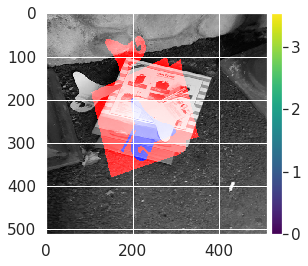

In [294]:
io.imshow(color.label2rgb(masks[0], images/255.0, colors=[(255,0,0),(0,0,255)], alpha=0.01, bg_label=0, bg_color=None))
plt.show()

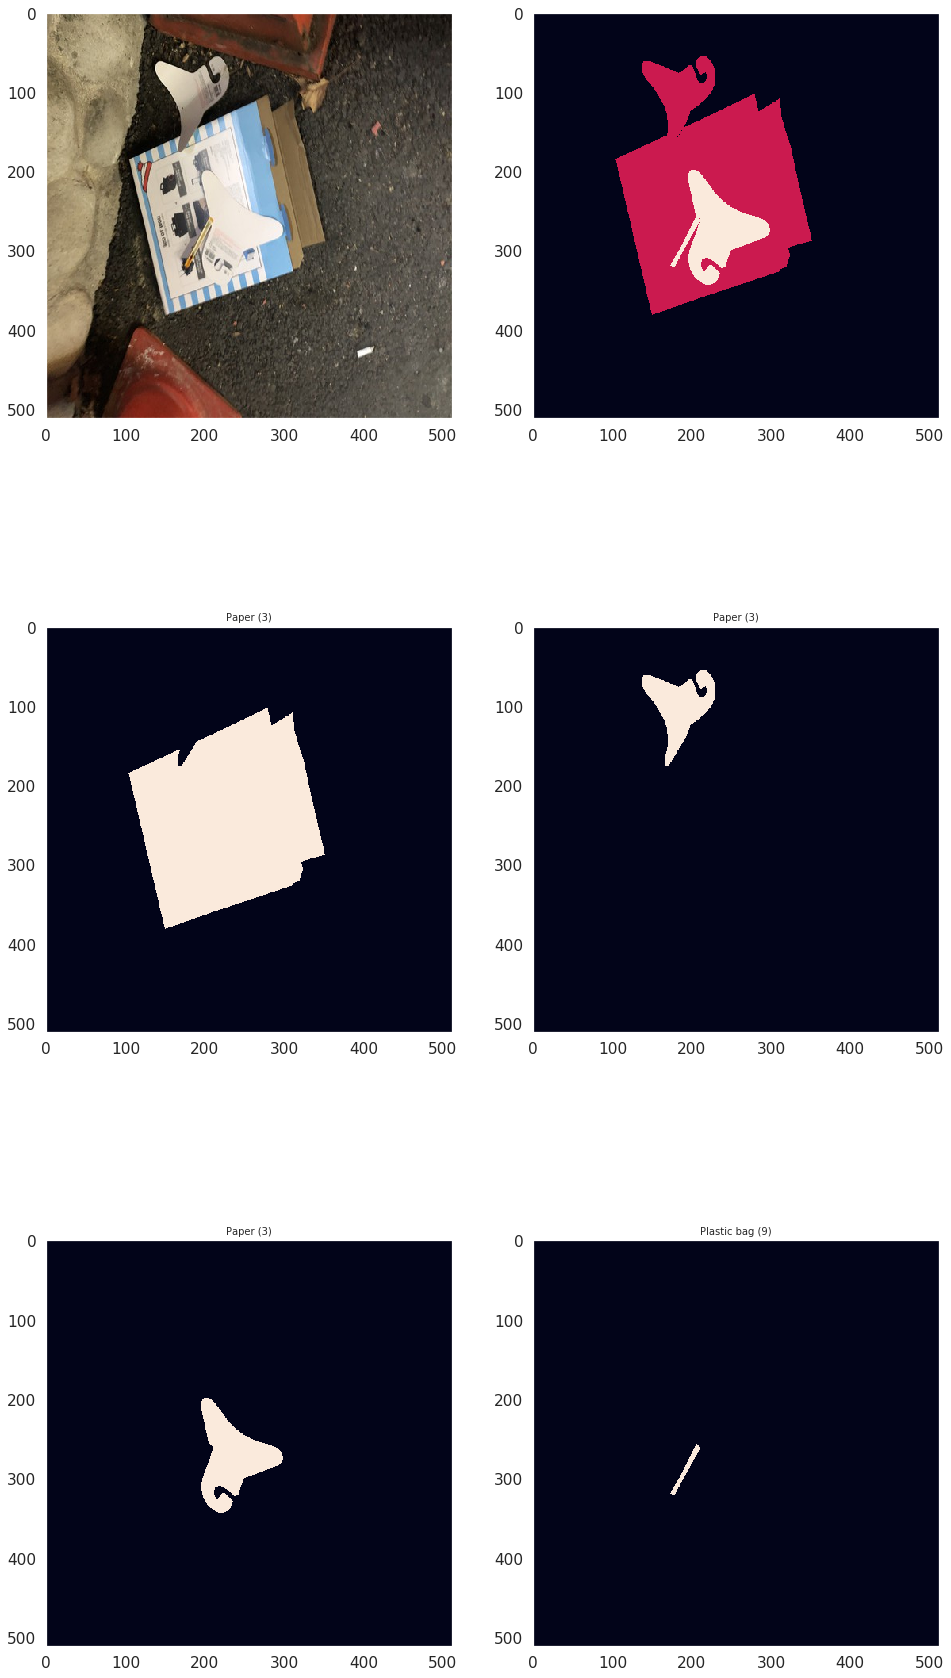

In [266]:
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(16, 32))
axes = axes.flatten()
if len(axes) > len(masks)+2:
    axes = axes[:-1]
    
axes[0].imshow(dd)
axes[0].grid(False)
for i, ax in enumerate(axes[1:]):
    ax.grid(False)
    ax.imshow(masks[i])
    if i > 0:
        cat_num = anns[i-1]['category_id'] + 1
        ax.set_title(f"{category_names[cat_num]} ({cat_num})", fontsize=10)

In [40]:
bb[0].dtype

dtype('uint8')

In [42]:
cc = np.zeros((4,4), dtype=np.ubyte)

In [44]:
cc[0] = 1

In [45]:
cc

array([[1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [54]:
bb[1] = (bb[1] == 1) | (cc == 1)

In [16]:
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [181]:
bb = torch.tensor([[[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]],

       [[1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=torch.float)

In [188]:
True & False

False

In [183]:
bb.shape

torch.Size([2, 4, 4])

In [187]:
torch.max(bb, dim=1)[0

torch.Size([2, 4])

In [5]:
d =[ [1.195540e+08, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 3.581690e+05
, 0.000000e+00, 0.000000e+00]
, [7.540700e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 3.780000e+02
,  0.000000e+00, 0.000000e+00]
, [3.549538e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 6.730400e+04
,  0.000000e+00, 0.000000e+00]
, [1.552370e+07, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.694980e+05
,  0.000000e+00, 0.000000e+00]
, [1.383114e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.200100e+04
,  0.000000e+00, 0.000000e+00]
, [1.585207e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 8.842000e+03
,  0.000000e+00, 0.000000e+00]
, [1.534297e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 3.910000e+02
,  0.000000e+00, 0.000000e+00]
, [4.179234e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.659620e+05
,  0.000000e+00, 0.000000e+00]
, [2.484627e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 8.267000e+04
,  0.000000e+00, 0.000000e+00]
, [1.262698e+07, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 7.453872e+06
,  0.000000e+00, 0.000000e+00]
, [6.195500e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00]
, [7.991820e+05, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00
,  0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 2.801100e+04
,  0.000000e+00, 0.000000e+00]]

In [6]:
d

[[119554000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 358169.0, 0.0, 0.0],
 [75407.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 378.0, 0.0, 0.0],
 [3549538.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67304.0, 0.0, 0.0],
 [15523700.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 169498.0, 0.0, 0.0],
 [1383114.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12001.0, 0.0, 0.0],
 [1585207.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8842.0, 0.0, 0.0],
 [1534297.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 391.0, 0.0, 0.0],
 [4179234.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 165962.0, 0.0, 0.0],
 [2484627.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 82670.0, 0.0, 0.0],
 [12626980.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7453872.0, 0.0, 0.0],
 [61955.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [799182.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28011.0, 0.0, 0.0]]

In [84]:
train_transform = A.Compose([
    # A.Resize(256,256),
    ToTensorV2()])
train_dataset = CustomDataLoader(train_path, mode='test', transform=train_transform)
test_loader = DataLoader(train_dataset, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.20s)
creating index...
index created!


In [81]:
model = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",
    classes=12,
)
model.load_state_dict(torch.load("/opt/ml/code/saved/DeepLabV3Plus_se_resnext101_32x4d_Search.pt"))

<All keys matched successfully>

In [82]:
model = model.to(device)

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Paper pack', 4}]


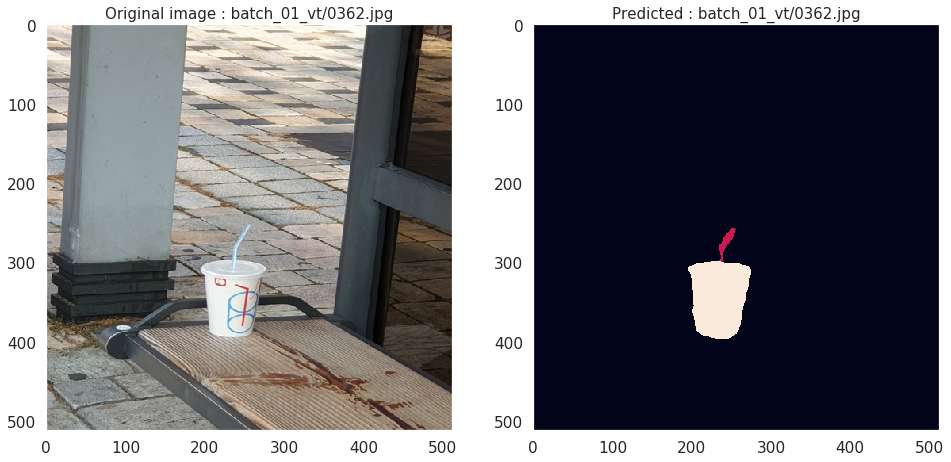

In [85]:
model.eval()
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

In [88]:
temp_images[0].shape

torch.Size([3, 512, 512])

In [127]:
a = set([0])

In [131]:
a.add(6)

In [133]:
list(a)

[0, 3, 6]

In [134]:
d1 = {"a":10}

In [135]:
d2 = {"bb":2}

In [141]:
d1.update(d2)

In [144]:
d1

{'a': 10, 'bb': 2}

In [143]:
d2

{'bb': 2}

In [148]:
c = {"bbb":50}.update(d1)

In [150]:
dict({"bbb":50}, **d2)

{'bbb': 50, 'bb': 2}

In [151]:
ddd = {}

In [154]:
ddd['100'] = 200

In [155]:
ddd

{'a': 200, '100': 200}

In [156]:
eee =[0,1,2,3,4]

In [157]:
for i, c in enumerate(eee):
    print(c)

0
1
2
3
4


In [162]:
dict(d1, **ddd)

{'a': 200, 'bb': 2, '100': 200}

In [163]:
existed_class = [0,4,5]

In [167]:
loss_dict = {}
for i, class_index in enumerate(existed_class):
    loss_dict[f"c{class_index}"] = 500

In [168]:
loss_dict

{'c0': 500, 'c4': 500, 'c5': 500}

In [169]:
some = [
    [
       [1,2,3],
        [2,3,4],
        [5,6,7]
        
    ]
    ,
    [
        [4,5],
        [2,3],
        [1,3]
    ]
]

In [170]:
some = np.array(some)

In [171]:
some.shape

(2, 3)

In [178]:
some[:, [[0,1],[1,2]]]

array([[[list([1, 2, 3]), list([2, 3, 4])],
        [list([2, 3, 4]), list([5, 6, 7])]],

       [[list([4, 5]), list([2, 3])],
        [list([2, 3]), list([1, 3])]]], dtype=object)

In [8]:
array =[[1.1761e+08,0.0000e+00,5.2906e+04,7.0221e+05,4.0449e+04,1.9506e+04
,1.8904e+05,3.9356e+05,7.1236e+04,7.9582e+05,0.0000e+00,3.5098e+04]
,[5.5140e+04,0.0000e+00,3.5000e+01,1.0701e+04,7.2200e+02,0.0000e+00
,6.6500e+02,1.0760e+03,1.2000e+03,5.8070e+03,0.0000e+00,4.3900e+02]
,[6.6373e+05,0.0000e+00,1.3877e+06,6.1643e+05,1.6019e+05,8.4158e+04
,2.4325e+04,1.7279e+05,3.1139e+04,4.6963e+05,0.0000e+00,6.7840e+03]
,[2.0181e+06,0.0000e+00,1.8858e+05,1.2477e+07,9.5124e+04,1.3931e+04
,3.4256e+04,7.8804e+04,1.1270e+05,5.9069e+05,0.0000e+00,8.3785e+04]
,[2.2893e+05,0.0000e+00,1.1470e+03,1.8784e+05,7.8246e+05,3.2793e+04
,3.5834e+04,7.4513e+04,3.3300e+03,4.8269e+04,0.0000e+00,0.0000e+00]
,[3.0674e+05,0.0000e+00,2.8841e+04,9.3802e+04,6.5053e+04,7.5102e+05
,3.8790e+04,1.9523e+05,1.6820e+03,1.1290e+05,0.0000e+00,0.0000e+00]
,[2.9499e+05,0.0000e+00,1.0216e+04,1.8450e+03,0.0000e+00,3.3340e+04
,9.0637e+05,2.4668e+05,0.0000e+00,4.1249e+04,0.0000e+00,0.0000e+00]
,[9.1976e+05,0.0000e+00,5.5020e+03,1.9008e+05,4.6399e+04,1.0389e+05
,1.8860e+05,2.1160e+06,3.8251e+04,7.2463e+05,0.0000e+00,1.2107e+04]
,[3.1003e+05,0.0000e+00,4.2030e+03,1.1352e+05,3.0737e+04,0.0000e+00
,4.3100e+03,5.7138e+04,1.8219e+06,2.2547e+05,0.0000e+00,0.0000e+00]
,[9.3455e+05,0.0000e+00,1.5882e+05,4.1339e+05,5.5959e+04,4.1166e+04
,2.4530e+03,1.6254e+05,1.8550e+04,1.8293e+07,0.0000e+00,3.2000e+01]
,[5.8723e+04,0.0000e+00,0.0000e+00,2.2470e+03,0.0000e+00,0.0000e+00
,9.8500e+02,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00]
,[2.4507e+05,0.0000e+00,6.8490e+03,4.6310e+03,0.0000e+00,0.0000e+00
,1.4137e+04,1.0555e+05,0.0000e+00,1.1640e+05,0.0000e+00,3.3456e+05]]

In [14]:
np.set_printoptions(precision=3, suppress=True)


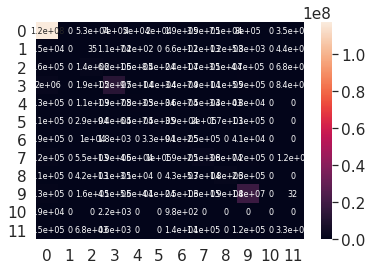

In [15]:
df_cm = pd.DataFrame(array, range(12), range(12))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

plt.show()

In [336]:
from datetime import datetime, timedelta

In [338]:
now = datetime.now() + timedelta(hours=9)
now = now.strftime("%H-%M")

In [346]:
type(now)

str